#### Data Analysis 2

### Assignment 2
Alejandra Savage Briz


Nicolás Fernandez


 
**Central European University**

#### Importing py_helper_funtions

In [1]:
# Import packages
####################################################
import copy
from typing import List

import numpy as np
import numpy.typing as npt
import pandas as pd
from plotnine import *

####################################################
# Define global vars
####################################################
color = ["#3a5e8cFF", "#10a53dFF", "#541352FF", "#ffcf20FF", "#2f9aa0FF"]


####################################################
# Define helper functions
####################################################
def seq(start: float, stop: float, by: float, round_n=3) -> list:
    """
    Custom function, used for setting the breaks of plotnine scales.

       Parameters
    ----------
    start : float
        Start of the breaks.
    stop : float
        End of the breaks.
    by : float
        Steps between breaks.
    round_n: int, default=3
        Decimals to round floats in output.
    """
    epsilon = np.finfo("float").eps

    return [
        round(x, round_n) for x in list(np.arange(start, stop + (by - epsilon), by))
    ]


def skew(l: npt.ArrayLike, round_n=3) -> float:
    return round((np.mean(l) - np.median(l)) / np.std(l), round_n)


def knot_ceil(vector: np.array, knot: float) -> np.array:
    vector_copy = copy.deepcopy(vector)
    vector_copy[vector_copy > knot] = knot
    return vector_copy


def lspline(series: pd.Series, knots: List[float]) -> np.array:
    """
    Function to create design matrix to esitmate a piecewise
    linear spline regression.

       Parameters
    ----------
    series : pd.Series
        Your variable in a pandas Series.
    knots : List[float]
        The knots, that result in n + 1 line segments.
    """

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix


def create_calibration_plot(
    data: pd.DataFrame,
    file_name: str,
    prob_var: str,
    actual_var: str,
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    """
    Function to create calibration curve.
    Returns calibration curve on a plot.

       Parameters
    ----------
    data : pd.DataFrame
        Your dataframe, containing the actual outcome and
        the predicted probabilities of that outcome
        by a model.
    file_name : str
        Filename to save. NOTE: this is note used for now.
    prob_var : str
        Name of the variable, containin predicted
        probabilities.
    actual_var : str
        Name of the actual outcome variable.
    y_lab: str
        Label on y axis of the plot.
    n_bins : int, default=10
        The number of bins, you would like to create.
        This is because with many values for the predicted probabilities,
        we may have few observations to look at for each value.
    breaks (optional): list or None
        You can speficy the breaks of the plot.
    """

    if breaks is None:
        breaks = np.around(
            np.linspace(0, (n_bins + 1) / 10, num=n_bins + 1, endpoint=False),
            decimals=1,
        ).tolist()

    data["prob_bin"] = pd.cut(data[prob_var], breaks, right=True, include_lowest=True)

    binned_data = (
        data.groupby("prob_bin")
        .agg(
            mean_prob=(prob_var, "mean"),
            mean_actual=(actual_var, "mean"),
            n=(actual_var, "size"),
        )
        .reset_index()
    )

    return (
        ggplot(binned_data, aes("mean_prob", "mean_actual"))
        + geom_line(color=color[0], size=1, show_legend=True)
        + geom_point(color=color[0], size=1, alpha=0.7, show_legend=False, na_rm=True)
        + geom_segment(
            x=min(breaks),
            xend=max(breaks),
            y=min(breaks),
            yend=max(breaks),
            color=color[1],
            size=0.5,
        )
        + theme_bw()
        + labs(x="Predicted event probability", y=y_lab)
        + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
        + expand_limits(x=0.01, y=0.01)
        + scale_y_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
        + scale_x_continuous(expand=(0.01, 0.01), breaks=(seq(0, 1.1, 0.1)))
    )


def poly(x: npt.ArrayLike, degree=1) -> pd.DataFrame:
    """
    Fit polynomial.

    These are non orthogonal factors, but it may not matter if
    we only need this for predictions (without interpreting the
    coefficients) or visualisation.

    Parameters
    ----------
    x : npt.ArrayLike
        Data array.
    degree : int, default=1
        Degree of the polynomial.
    """
    d = {}
    for i in range(degree + 1):
        if i == 1:
            d["x"] = x
        else:
            d[f"x**{i}"] = np.power(x, i)
    return pd.DataFrame(d)


def price_diff_by_variables(
    df: pd.DataFrame, factor_var: str, dummy_var: str, factor_lab: str, dummy_lab: str
) -> ggplot:
    """
    Price difference by selected factor and dummy variables.

    This function creates a barplots looking for interactions.
    Used in `ch14-airbnb-prediction.ipynb`.

        Parameters
    ----------
    df : pd.DataFrame
        Your dataframe.
    factor_var : str
        Your factor variable (like room_type).
    dummy_var : str
        The dummy variable you are interested in (like TV).
    factor_lab : str
        The label on the final plot for the `factor_var`.
    dummy_lab : str
        The label on the final plot for the `dummy_var`.
    """

    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), sd=("price", np.std), size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1 / 2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    return (
        ggplot(
            stats,
            aes(
                stats.columns[0],
                stats.columns[2],
                fill="factor(" + stats.columns[1] + ")",
            ),
        )
        + geom_bar(stat="identity", position=position_dodge(width=0.9))
        + geom_errorbar(
            aes(ymin="Mean_l", ymax="Mean_u"),
            position=position_dodge(width=0.9),
            width=0.25,
        )
        + scale_color_manual(name=dummy_lab, values=(color[1], color[0]))
        + scale_fill_manual(name=dummy_lab, values=(color[1], color[0]))
        + ylab("Mean Price")
        + xlab(factor_lab)
        + theme_bw()
        + theme(
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            panel_border=element_blank(),
            axis_line=element_line(),
            legend_position="top",
            legend_box="vertical",
            legend_text=element_text(size=5),
            legend_title=element_text(size=5, face="bold"),
        )
    )


import statsmodels.formula.api as smf
from sklearn.model_selection import KFold
from statsmodels.tools.eval_measures import rmse


def ols_crossvalidator(
    formula: str, data: pd.DataFrame, n_folds=5, average_rmse=True
) -> dict:
    """OLS cross-validator


    Estimates `formula` equation with OLS and returns values of RMSE, R`2, No. coefficients,
    BIC on `data`. Does k-fold cross-validation and either returns train and test RMSE for each
    fold, or return averarage train and test RMSEs.

    Parameters
    ----------
    formula : str
        Equation that is estimated by OLS.
    data : pd.DataFrame
        Database in a wide format.
    n_folds : int, default=5
        Number of folds. Must be at least 2.
    average_rmse : bool, default=True
        Whether to return the average train and test RMSE of the k-fold CV, or return
        train and test RMSE-s for each fold.

    """

    # Get dependent variable

    y = formula.split("~")[0].strip()

    # Get statistics on the whole work data

    model = smf.ols(formula, data=data).fit()

    rsquared = model.rsquared
    # n_coefficients = model.params.shape[0]
    n_coefficients = (
        model.df_model + 1
    )  # This might differ from model.params.shape[0], because of collinear predictors
    bic = model.bic
    rmse_alldata = rmse(model.predict(), data[y])

    # Calculating test and train RMSE-s for each fold

    k = KFold(n_splits=n_folds, shuffle=False, random_state=None)

    rmse_train = []
    rmse_test = []

    for train_index, test_index in k.split(data):

        data_train, data_test = data.iloc[train_index, :], data.iloc[test_index, :]

        model = smf.ols(formula, data=data_train).fit()

        rmse_train.append(rmse(data_train[y], model.predict(data_train)))
        rmse_test.append(rmse(data_test[y], model.predict(data_test)))

    if average_rmse:
        rmse_train = np.mean(rmse_train)
        rmse_test = np.mean(rmse_test)

    return {
        "RMSE": rmse_alldata,
        "R-squared": rsquared,
        "BIC": bic,
        "Coefficients": n_coefficients,
        "Training RMSE": rmse_train,
        "Test RMSE": rmse_test,
    }


import statsmodels


def point_predict_with_conf_int(
    regression: statsmodels.regression.linear_model.RegressionResultsWrapper,
    new_datapoint: pd.DataFrame,
    interval_precision=0.95,
    round_n=2,
) -> dict:
    """
    Does point prediction and interval prediction for a new datapoint.

        Parameters
    ----------
    regression : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted regression model.
    new_datapoint : pd.DataFrame
        Database containing a new observation.
    interval_precision : float, default=0.95
        Precision of interval prediction.
    round_n: int, default=2
        Decimals to round floats in output.
    """

    summaryframe = regression.get_prediction(new_datapoint).summary_frame(
        alpha=1 - interval_precision
    )

    point_prediction = round(summaryframe["mean"].values[0], round_n)

    conf_int = [
        round(i, round_n)
        for i in summaryframe[["obs_ci_lower", "obs_ci_upper"]].values[0]
    ]

    if round_n == 0:
        point_prediction = int(point_prediction)
        conf_int = [int(i) for i in conf_int]
    else:
        pass

    return {
        "Point prediction": point_prediction,
        f"Prediction Interval ({round(interval_precision*100)}%)": conf_int,
    }


class Error(Exception):
    """Base class for other exceptions"""

    pass


class ConfintError(Error):
    """
    Error raised when a confidence interval
    does not match with required format.
    """

    def __init__(
        self,
        message="Confidence intervals are two numbers, so len(conf_int) must be 2.",
    ):
        self.message = message
        super().__init__(self.message)


def format_confidence_interval(conf_int: List[float], round_n=2) -> str:
    """Format confidence interval.

        Parameters
    ----------
    conf_int: np.array
        Array, consisting upper and upper confidence interval values.
    round_n: int, default=2
        Decimals to round floats in output.
    """
    if len(conf_int) != 2:
        raise ConfintError
    elif round_n == 0:
        return "[" + "–".join([str(int(round(i, round_n))) for i in conf_int]) + "]"
    else:
        return "[" + "–".join([str(round(i, round_n)) for i in conf_int]) + "]"


def create_sample_frame(
    vector: np.array, sample_size: int, n_samples=10000, with_replacement=False, seed=42
) -> List[np.array]:
    """
    Function for a specified number of samples.
    Draws a specified number of observations from a vector, either with or without replacement.
    Returns the matrix of samples.

    Used in `ch05-stock-market-loss-generalize.ipynb`

       Parameters
    ----------
    vector : np.array
        Vector of observations.
    sample_size : int
        Sample size, you want to draw.
        Set it len(vector) for bootstrap sampling.
    n_samples : int, default=10000
        Number of samples.
    with_replacement : bool, default=False
        Whether to perform sampling with or without
        replacement. Set `True` for bootstrap sampling.
    seed : int,default=42
        Random seed for reproducibility.
    """

    rng = np.random.default_rng(seed)
    sample_frame = np.zeros((n_samples, sample_size))
    for i in range(n_samples):
        sample_frame[i] = rng.choice(vector, size=sample_size, replace=with_replacement)

    return sample_frame


def add_margin(ax, x=0.05, y=0.05) -> None:
    """
    This will, by default, add 5% to the x and y margins to matplotlib plots.
    You can customise this using the x and y arguments when you call it.

       Parameters
    ----------
    ax : matplotlib.axes._subplots.AxesSubplot
        Vector of observations.
    x : float,default=0.05
        Margin to add for x axis.
    y : float,default=0.05
        Margin to add for x axis.
    """

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xmargin = (xlim[1] - xlim[0]) * x
    ymargin = (ylim[1] - ylim[0]) * y

    ax.set_xlim(xlim[0] - xmargin, xlim[1] + xmargin)
    ax.set_ylim(ylim[0] - ymargin, ylim[1] + ymargin)

#### Importing libraries

In [4]:
import os
from pathlib import Path
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from scipy.stats import logistic
from scipy.stats import norm
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from mizani import transforms
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

warnings.filterwarnings("ignore")

## Loading datasets: hotel_features and hotel_prices

In [5]:
# Load the data from CSV files
hotels_features = pd.read_csv('hotels-europe_features.csv')
hotels_price= pd.read_csv('hotels-europe_price.csv')

In [6]:
# Checking values of hotels and countries
hotels_features['city'].value_counts()

Rome              4883
Paris             2184
London            1401
Istanbul          1377
Milan             1098
Barcelona          835
Madrid             708
Lisbon             671
St. Petersburg     663
Prague             635
Berlin             579
Vienna             516
Naples             509
Krakow             431
Amsterdam          429
Moscow             400
Athens             369
Munich             360
Warsaw             345
Budapest           340
Salzburg           339
Brussels           333
Lyon               312
Dublin             309
Stockholm          259
Hamburg            257
Seville            231
Marseille          212
Birmingham         185
Dubrovnik          181
Glasgow            162
Kiev               134
Bucharest          132
Riga               131
Copenhagen         121
Belgrade           111
Bratislava         104
Helsinki           103
Sofia              101
Rotterdam           94
Tallin              90
Vilnius             88
Zagreb              60
Minsk      

We select **Madrid** for the analysis of this assignment since it has more than 250 values (708 values).

In [7]:
# Check shape of 'Madrid' hotels in the data
filter_test_madrid = hotels_features.loc[hotels_features["city"].isin(['Madrid'])]
filter_test_madrid.shape

(708, 15)

## Merging datasets

In [8]:
# Merge the DataFrames using a common column 'hotel_id'
merged_hotels = pd.merge(hotels_features, hotels_price, on='hotel_id')

In [9]:
# Display of merged_hotels DataFrame
merged_hotels

,hotel_id,city,distance,stars,rating,country,city_actual,rating_reviewcount,center1label,center2label,...,accommodation_type,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room
0,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,172,0,0% no offer,2017,11,1,0,1,0
1,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,122,1,15-50% offer,2018,1,1,0,1,0
2,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,122,1,15-50% offer,2017,12,0,1,1,0
3,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,552,1,1-15% offer,2017,12,0,1,4,0
4,1,Amsterdam,3.1,4.0,4.3,Netherlands,Amsterdam,1030.0,City centre,Montelbaanstoren,...,Hotel,122,1,15-50% offer,2018,2,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148016,22902,Zagreb,1.1,4.0,4.5,Croatia,Zagreb,48.0,City centre,Zagreb City Museum,...,Hotel,119,1,15-50% offer,2017,11,0,0,1,1
148017,22902,Zagreb,1.1,4.0,4.5,Croatia,Zagreb,48.0,City centre,Zagreb City Museum,...,Hotel,109,1,15-50% offer,2018,4,1,0,1,1
148018,22902,Zagreb,1.1,4.0,4.5,Croatia,Zagreb,48.0,City centre,Zagreb City Museum,...,Hotel,109,1,15-50% offer,2018,3,1,0,1,1
148019,22902,Zagreb,1.1,4.0,4.5,Croatia,Zagreb,48.0,City centre,Zagreb City Museum,...,Hotel,446,1,15-50% offer,2017,12,0,1,4,1


## Data cleaning/Filters

In [11]:
# Filtering for Madrid
filter_test = merged_hotels.loc[merged_hotels["city"].isin(['Madrid'])]
filter_test.shape

(4593, 24)

Selecting only **Hotel** type of accommodation

In [12]:
# Filter for Hotel accommodation type
filter_test = filter_test.loc[filter_test["accommodation_type"] == "Hotel"]
filter_test.shape

(3003, 24)

In [13]:
filter_test.columns

Index(['hotel_id', 'city', 'distance', 'stars', 'rating', 'country',
       'city_actual', 'rating_reviewcount', 'center1label', 'center2label',
       'neighbourhood', 'ratingta', 'ratingta_count', 'distance_alter',
       'accommodation_type', 'price', 'offer', 'offer_cat', 'year', 'month',
       'weekend', 'holiday', 'nnights', 'scarce_room'],
      dtype='object')

In [14]:
filter_test

,hotel_id,city,distance,stars,rating,country,city_actual,rating_reviewcount,center1label,center2label,...,accommodation_type,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room
63621,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,117,1,15-50% offer,2018,5,1,0,1,0
63622,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,119,1,15-50% offer,2018,6,1,0,1,0
63623,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,353,1,50%-75% offer,2017,12,0,1,4,0
63624,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,100,1,15-50% offer,2018,2,1,0,1,0
63625,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,88,1,50%-75% offer,2017,12,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68200,9583,Madrid,16.0,3.0,4.0,Spain,Torrelodones,59.0,City centre,Casa Matesanz,...,Hotel,73,1,1-15% offer,2018,1,1,0,1,0
68201,9583,Madrid,16.0,3.0,4.0,Spain,Torrelodones,59.0,City centre,Casa Matesanz,...,Hotel,66,1,15-50% offer,2017,12,0,1,1,0
68202,9583,Madrid,16.0,3.0,4.0,Spain,Torrelodones,59.0,City centre,Casa Matesanz,...,Hotel,84,0,0% no offer,2018,3,1,0,1,0
68203,9583,Madrid,16.0,3.0,4.0,Spain,Torrelodones,59.0,City centre,Casa Matesanz,...,Hotel,87,0,0% no offer,2018,4,1,0,1,0


Selecting only Madrid hotels **on weekends** and **not available on holidays** as well as the sample in **2018**.

In [15]:
# Creating a DataFrame for all Madrid hotels on weekends and not on holidays
madrid_hotels_wh = filter_test[(filter_test['weekend'] == 1) & (filter_test['holiday'] == 0)].copy()

# Selecting only 2018 
madrid_hotels_wh = filter_test[(filter_test['year'] == 2018)].copy()

In [16]:
# Drop hotels that are in 'Madrid' but have different values in 'city_actual' column
# Checking that 'Madrid' is the city in both 'city' and 'city_actual' columns

madrid_hotels=madrid_hotels_wh[(madrid_hotels_wh['city'] == 'Madrid') & (madrid_hotels_wh['city_actual'] == 'Madrid')]
madrid_hotels

,hotel_id,city,distance,stars,rating,country,city_actual,rating_reviewcount,center1label,center2label,...,accommodation_type,price,offer,offer_cat,year,month,weekend,holiday,nnights,scarce_room
63621,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,117,1,15-50% offer,2018,5,1,0,1,0
63622,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,119,1,15-50% offer,2018,6,1,0,1,0
63624,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,100,1,15-50% offer,2018,2,1,0,1,0
63626,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,100,1,15-50% offer,2018,1,1,0,1,0
63627,8877,Madrid,2.2,3.0,4.1,Spain,Madrid,63.0,City centre,Casa Matesanz,...,Hotel,88,1,50%-75% offer,2018,4,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68107,9571,Madrid,2.7,4.0,4.0,Spain,Madrid,88.0,City centre,Casa Matesanz,...,Hotel,138,0,0% no offer,2018,1,1,0,1,0
68111,9572,Madrid,2.4,4.0,3.9,Spain,Madrid,223.0,City centre,Casa Matesanz,...,Hotel,109,1,15-50% offer,2018,1,1,0,1,0
68112,9572,Madrid,2.4,4.0,3.9,Spain,Madrid,223.0,City centre,Casa Matesanz,...,Hotel,125,1,15-50% offer,2018,4,1,0,1,0
68114,9572,Madrid,2.4,4.0,3.9,Spain,Madrid,223.0,City centre,Casa Matesanz,...,Hotel,109,1,15-50% offer,2018,2,1,0,1,0


In [17]:
# Drop columns
columns_to_drop = ['hotel_id','country', 'city_actual','city','offer', 'center1label', 'center2label', 'neighbourhood', 'offer_cat', 'nnights', 'scarce_room']
madrid_hotels = madrid_hotels.drop(columns=columns_to_drop)

In [18]:
madrid_hotels

,distance,stars,rating,rating_reviewcount,ratingta,ratingta_count,distance_alter,accommodation_type,price,year,month,weekend,holiday
63621,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,117,2018,5,1,0
63622,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,119,2018,6,1,0
63624,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,100,2018,2,1,0
63626,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,100,2018,1,1,0
63627,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,88,2018,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68107,2.7,4.0,4.0,88.0,4.0,613.0,2.5,Hotel,138,2018,1,1,0
68111,2.4,4.0,3.9,223.0,3.5,804.0,2.2,Hotel,109,2018,1,1,0
68112,2.4,4.0,3.9,223.0,3.5,804.0,2.2,Hotel,125,2018,4,1,0
68114,2.4,4.0,3.9,223.0,3.5,804.0,2.2,Hotel,109,2018,2,1,0


In [19]:
madrid_hotels.describe()

,distance,stars,rating,rating_reviewcount,ratingta,ratingta_count,distance_alter,price,year,month,weekend,holiday
count,1395.000000,1395.000000,1373.000000,1373.000000,1373.000000,1373.000000,1395.000000,1395.000000,1395.0,1395.000000,1395.0,1395.0
mean,2.191613,3.701792,4.117698,242.032775,4.029862,945.775674,2.118065,171.848746,2018.0,3.397849,1.0,0.0
std,2.307649,0.806379,0.365394,227.686091,0.451169,723.966949,2.265673,116.635556,0.0,1.702432,0.0,0.0
min,0.100000,1.000000,2.200000,16.000000,2.000000,16.000000,0.000000,32.000000,2018.0,1.000000,1.0,0.0
25%,0.400000,3.000000,4.000000,101.000000,4.000000,438.000000,0.400000,101.000000,2018.0,2.000000,1.0,0.0
50%,1.200000,4.000000,4.100000,183.000000,4.000000,791.000000,1.100000,149.000000,2018.0,3.000000,1.0,0.0
75%,3.600000,4.000000,4.400000,306.000000,4.500000,1288.000000,3.350000,204.000000,2018.0,5.000000,1.0,0.0
max,8.800000,5.000000,4.900000,1855.000000,5.000000,4211.000000,8.700000,1141.000000,2018.0,6.000000,1.0,0.0


## Using IQR to eliminate outliers

In [20]:
# Removing distance outliers
# Calculate the first quartile (Q1)
Q1 = madrid_hotels['distance'].quantile(0.25)

# Calculate the third quartile (Q3)
Q3 = madrid_hotels['distance'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

In [21]:
# Filter rows within the IQR range for a specific column
hotels = madrid_hotels[(madrid_hotels['distance'] >= Q1 - 1.5 * IQR) & (madrid_hotels['distance'] <= Q3 + 1.5 * IQR)]

## Using hotel user ratings to create a binary variable: highly_rated=1 if rating ≥ 4, 0 otherwise

In [22]:
# Creating binary variable for highly_rated hotels
hotels['highly_rated'] = (hotels['rating'] >= 4).astype(int)

In [23]:
# Check to see the added new column
hotels

,distance,stars,rating,rating_reviewcount,ratingta,ratingta_count,distance_alter,accommodation_type,price,year,month,weekend,holiday,highly_rated
63621,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,117,2018,5,1,0,1
63622,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,119,2018,6,1,0,1
63624,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,100,2018,2,1,0,1
63626,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,100,2018,1,1,0,1
63627,2.2,3.0,4.1,63.0,4.0,363.0,2.3,Hotel,88,2018,4,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68107,2.7,4.0,4.0,88.0,4.0,613.0,2.5,Hotel,138,2018,1,1,0,1
68111,2.4,4.0,3.9,223.0,3.5,804.0,2.2,Hotel,109,2018,1,1,0,0
68112,2.4,4.0,3.9,223.0,3.5,804.0,2.2,Hotel,125,2018,4,1,0,0
68114,2.4,4.0,3.9,223.0,3.5,804.0,2.2,Hotel,109,2018,2,1,0,0


## Examine how high rating is related to the other hotel features in the data

In [24]:
# Renaming column 'rating_reviewcount' to 'reviews'
hotels = hotels.rename(columns={"rating_reviewcount": "reviews"})

In [25]:
# Summary statistics for numerical features grouped by 'highly_rated'
numerical_cols = ['distance', 'stars', 'rating', 'price', 'reviews']
summary_stats = hotels.groupby('highly_rated')[numerical_cols].describe().round(2)
summary_statistics=summary_stats.transpose()
summary_statistics

highly_rated          0        1
distance count   321.00  1050.00
         mean      2.50     1.95
         std       2.33     2.09
         min       0.10     0.10
         25%       0.40     0.40
         50%       1.80     1.10
         75%       4.00     3.00
         max       8.40     7.90
stars    count   321.00  1050.00
         mean      3.22     3.85
         std       0.87     0.73
         min       1.00     1.00
         25%       3.00     4.00
         50%       3.00     4.00
         75%       4.00     4.00
         max       5.00     5.00
rating   count   299.00  1050.00
         mean      3.63     4.26
         std       0.33     0.23
         min       2.20     4.00
         25%       3.50     4.00
         50%       3.70     4.30
         75%       3.90     4.50
         max       3.90     4.90
price    count   321.00  1050.00
         mean    154.50   177.45
         std     168.43    93.43
         min      32.00    63.00
         25%      83.00   114.00
         50%     107.00   161.00
         75%     156.00   209.50
         max    1141.00   764.00
reviews  count   299.00  1050.00
         mean    169.96   259.85
         std     133.82   240.31
         min      16.00    16.00
         25%      85.00   108.00
         50%     125.00   207.00
         75%     202.00   327.00
         max     649.00  1855.00

In [26]:
# Statistic summary for all the variables
hotels.filter(
    [
        "distance",
        "stars",
        "rating",
        "price",
        "reviews",
    ]
).describe().round(2)

,distance,stars,rating,price,reviews
count,1371.00,1371.00,1349.00,1371.00,1349.00
mean,2.08,3.71,4.12,172.08,239.93
std,2.16,0.81,0.37,115.78,224.26
min,0.10,1.00,2.20,32.00,16.00
25%,0.40,3.00,4.00,103.00,101.00
50%,1.10,4.00,4.10,149.00,183.00
75%,3.30,4.00,4.40,204.00,306.00
max,8.40,5.00,4.90,1141.00,1855.00


**Interpretation**

- Hotels in Madrid in 2018 were generally well-rated, with an average rating of 4.12 out of 5. The average hotel had 3.71 stars and was located 2.08 kilometers from the city center. 

- Prices ranged from €32 to €1141 per night, with an average price of €172.08. 

- Hotels with more stars and those located closer to the city center tended to be more expensive. The average hotel had 239.93 reviews, with a range of 16 to 1855 reviews.

## Estimate linear probability model (LPM) with distance and stars as explanatory variables

## Recap theory
### Linear probability model
-> **linear** models with **binary y**

$y^P = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots$

- $\beta_0$: probability that y=1 for observations where all variables=0
- $\beta_1$: by how much probability of y=1 is higher for observations with 1 unit higher $x_1$, the rest constant
- $\beta_2$: by how much probability of y=1 is higher for observations with 1 unit higher $x_2$, the rest constant
- $\dots$

-> main issue: the estimated probabilities are not restricted between 0 and 1 (problem for prediction, not for simply uncovering associations)

-> errors are heteroskedastic by construction!

**Model 1**: estimate linear probability model
- being highly rated (*highly_rated*) as the binary dependent variable 
- distance as explanatory variable (*distance*)

In [27]:
# Linear regression models
lpm1 = smf.ols("highly_rated ~ distance", data=hotels).fit(cov_type="HC1")

**Model 2**: estimate linear probability model
- being highly rated (*highly_rated*) as the binary dependent variable 
- stars as explanatory variable (*stars*)

In [28]:
lpm2 = smf.ols("highly_rated ~ stars", data=hotels).fit(cov_type="HC1")

**Model 3**: estimate linear probability model
- being highly rated (*highly_rated*) as the binary dependent variable 
- distance and stars as explanatory variables (*distance+stars*)

In [29]:
lpm3= smf.ols("highly_rated ~ distance+stars",data=hotels).fit(cov_type="HC1")

### Table 1. Probability of being a highly rated hotel based on distance and stars

In [30]:
# Stargazer for model visualization
stargazer = Stargazer([lpm3])
stargazer.covariate_order(["distance", "stars", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

- For each additional kilometer that a hotel is located from the city center, the **probability of it being highly rated decreases by 2%.**

- For each additional star that a hotel has, the probability of it being highly rated increases by 0.173. In other words, a hotel with 5 stars is **17.3% more likely to be highly rated than a hotel with 1 star.**


The coefficient for stars is 0.173, suggesting a positive and statistically significant relationship (p < 0.01). This indicates that as the number of stars a hotel possesses increases, the probability of it being highly rated also rises.

The constant term is 0.170, indicating a positive and statistically significant relationship (p < 0.01). This implies that even for a hotel located at a distance of 0 kilometers from the city center and having only 1 star, there's still a 17% chance of it being considered highly rated.

Hotels located closer to the city center and having a higher star rating are more likely to be perceived as highly rated. The coefficient for distance is -0.021, indicating a negative and statistically significant relationship (p < 0.01). This implies that as the distance of a hotel from the city center increases, the likelihood of it being highly rated decreases. 

### Models confidence intervals

In [31]:
lpm1.conf_int(alpha=0.01)
#filter by miles
#one additional mile affects rating

,0,1
Intercept,0.770254,0.848852
distance,-0.035421,-0.006643


**Model 1**: $highly_rated^P=\alpha+\beta distance$
- $\alpha$: 77% of hotels located at a distance of 0 kilometers from the city center (𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒=0) were highly rated.
- $\beta$: Hotels located further away from the city center (higher values of distance) were 3.54% less likely to be highly rated.
> Intercept (𝛼): The confidence interval for the intercept ranges from 0.770254 to 0.848852. This means that we can be 99% confident that the true value of the intercept lies between these two values.

> Distance coefficient (𝛽): The confidence interval for the distance coefficient ranges from -0.035421 to -0.006643. This means that we can be 99% confident that the true value of the distance coefficient lies between these two values.
estimates are statistically significant at 1%

- Both the intercept and the distance coefficient are statistically significant at the 1% level. This means that we can reject the null hypothesis that either coefficient is equal to zero.

- We can be 99% confident that hotels with less distance to the city center are less likely to be highly rated in the population (represented by the dataset). We can also be 99% confident that the distance hotels in the population (represented by the dataset) stay highly rated with a lower probability of 1.1 to 2.3 percentage points.

In [32]:
lpm2.conf_int(alpha=0.01)

,0,1
Intercept,-0.016210,0.267510
stars,0.137703,0.207861


**Model 2**: $highly_rated^P=\alpha+\beta stars$
- $\alpha$: -1.62% of hotels with zero stars (𝑠𝑡𝑎𝑟𝑠=0) were highly rated.
- $\beta$: For each additional star a hotel has, the probability of being highly rated increases by 13.77%.

> Intercept (𝛼): The confidence interval for the intercept ranges from -0.016210 to 0.267510. This means that we can be 99% confident that the true value of the intercept lies between these two values.

> Distance coefficient (𝛽): The confidence interval for the stars coefficient ranges from 0.137703 to 0.207861. This means that we can be 99% confident that the true value of the stars coefficient lies between these two values.

- The stars coefficient is statistically significant at the 1% level. This means that we can reject the null hypothesis that the stars coefficient is equal to zero. The intercept is not statistically significant.

- We can be 99% confident that there is a significant relationship between the number of stars a hotel has and its probability of being highly rated. For each additional star a hotel has, the probability of being highly rated increases by 13.77%. However, we cannot be 99% confident that the intercept is different from zero. This means that we cannot be certain whether there is a non-zero probability of a hotel with zero stars being highly rated.

In [33]:
lpm3.conf_int(alpha=0.01)

,0,1
Intercept,0.023198,0.315853
distance,-0.034210,-0.007513
stars,0.137653,0.207619


**Model 3**: $highly_rated^P=\beta_0+\beta_1 distance +\beta_2 stars$
- $\beta_0$: 2.32% of hotels located at a distance of 0 kilometers from the city center (𝑑𝑖𝑠𝑡𝑎𝑛𝑐𝑒=0) were highly rated.

- $\beta_1$: For each additional kilometer a hotel is located from the city center (higher values of distance), the probability of it being highly rated decreases by 3.42%.

- $\beta_2$: For each additional star a hotel has, the probability of it being highly rated increases by 13.77%.

Both the distance coefficient (𝛽1) and the stars coefficient (𝛽2) are statistically significant at the 1% level. This means that we can reject the null hypothesis that either coefficient is equal to zero.

- Distance from the city center and the number of stars are both significant factors in determining whether a hotel is highly rated. Hotels located closer to the city center and having a higher star rating are more likely to be highly rated.

### Prediction creation

In [35]:
# Prediction creation
# Model 1: highly_rated and distance
hotels["pred1"] = lpm1.predict()

In [36]:
# Prediction creation
# Model 2: highly_rated and stars

hotels["pred_2"] = lpm2.predict()

In [37]:
# Prediction creation
# Model 3: highly_rated and distance+stars

hotels["pred_lpm"] = lpm3.predict()

In [38]:
hotels["pred_lpm"].describe().round(4)

count    1371.0000
mean        0.7659
std         0.1471
min         0.1815
25%         0.6812
50%         0.7912
75%         0.8496
max         1.0285
Name: pred_lpm, dtype: float64

The __median predicted probability__ is **0.7912**, which is slightly higher than the mean predicted probability
> The distribution of predicted probabilities is slightly skewed to the right.
> The model predicts that 76.59% of the hotels in the dataset will be highly rated. 

The __standard deviation__ is **0.1471+*, which means that there is a fair amount of variability in the predicted probabilities. The minimum predicted probability is 0.1815, and the maximum predicted probability is 1.0285.

### Highly rated and distance

In [39]:
pd.crosstab(index=hotels["highly_rated"], columns=hotels["distance"])

distance,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,...,6.7,6.8,7.0,7.3,7.4,7.5,7.6,7.7,7.9,8.4
highly_rated,,,,,,,,,,,,,,,,,,,,,
0,17,29,21,16,24,0,9,6,0,0,...,0,0,12,0,0,0,6,6,0,6
1,35,98,124,45,36,25,40,42,40,35,...,12,6,6,6,15,8,0,6,6,0


In [40]:
hotels["weight"] = hotels.groupby(["distance", "highly_rated"])["distance"].transform(len)
hotels["weight_2"] = hotels["weight"] / 1000

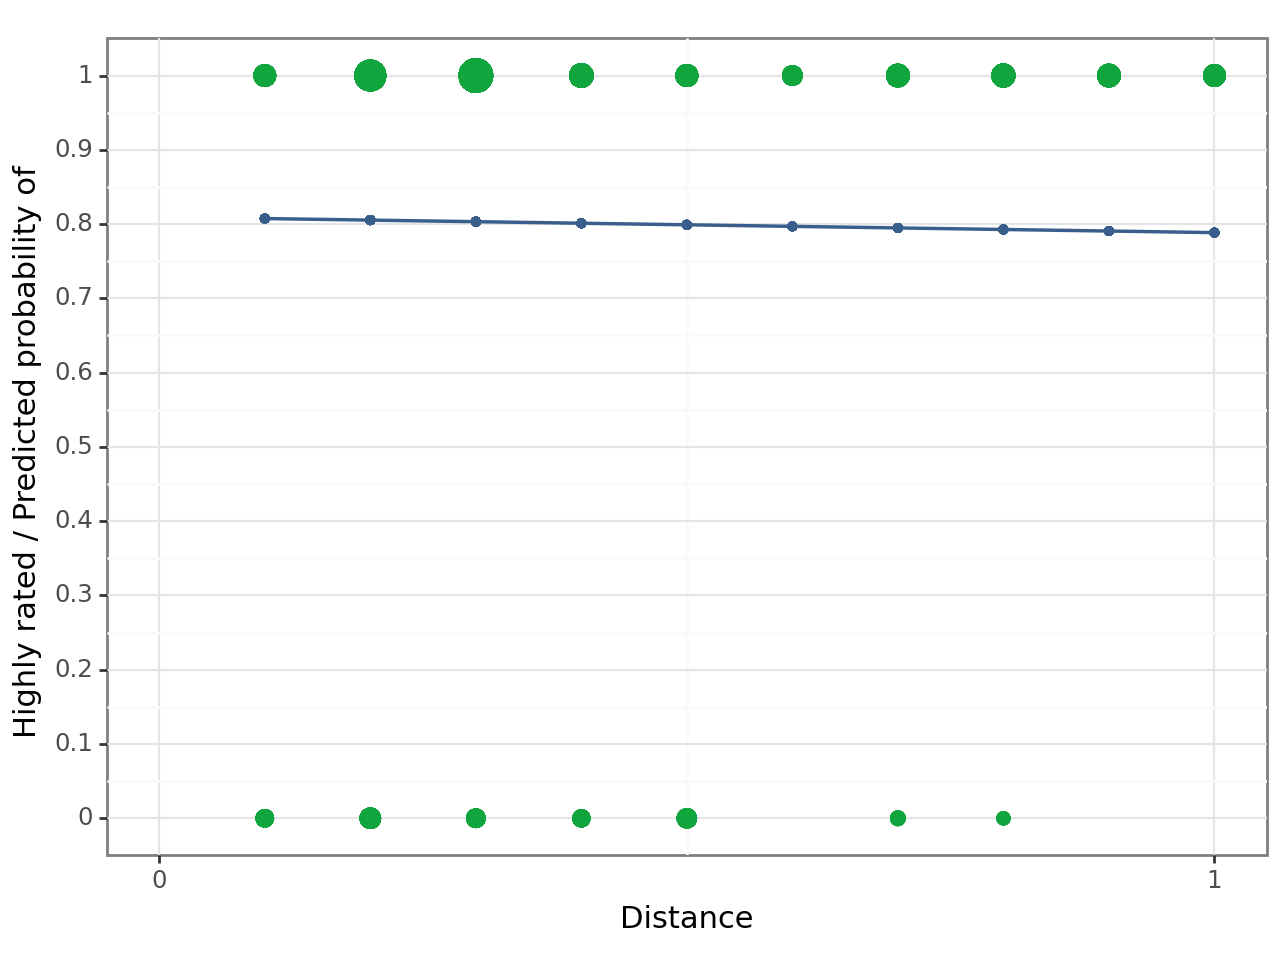

<Figure Size: (640 x 480)>

In [41]:
g1 = (
    ggplot(data=hotels)
    + geom_point(aes(x="distance", y="pred1"), size=1, color=color[0])
    + geom_line(aes(x="distance", y="pred1"), colour=color[0], size=0.7)
    + geom_point(
        aes(x="distance", y="highly_rated", size="weight_2"),
        fill=color[1],
        color=color[1],
        alpha=0.8,
        show_legend=False,
    )
    + labs(x="Distance", y="Highly rated / Predicted probability of ")
    + coord_cartesian(xlim=[0, 1], ylim=[0, 1])
    + scale_y_continuous(limits=[0, 1], breaks=seq(0, 1, 0.1))
    + scale_x_continuous(limits=[0, 1], breaks=seq(0, 1, 1))
    + theme_bw()
)
g1

### Highly rated and stars

In [42]:
pd.crosstab(index=hotels["highly_rated"], columns=hotels["stars"])

stars,1.0,2.0,3.0,3.5,4.0,4.5,5.0
highly_rated,,,,,,,
0,15,42,128,4,120,6,6
1,4,46,203,6,632,6,153


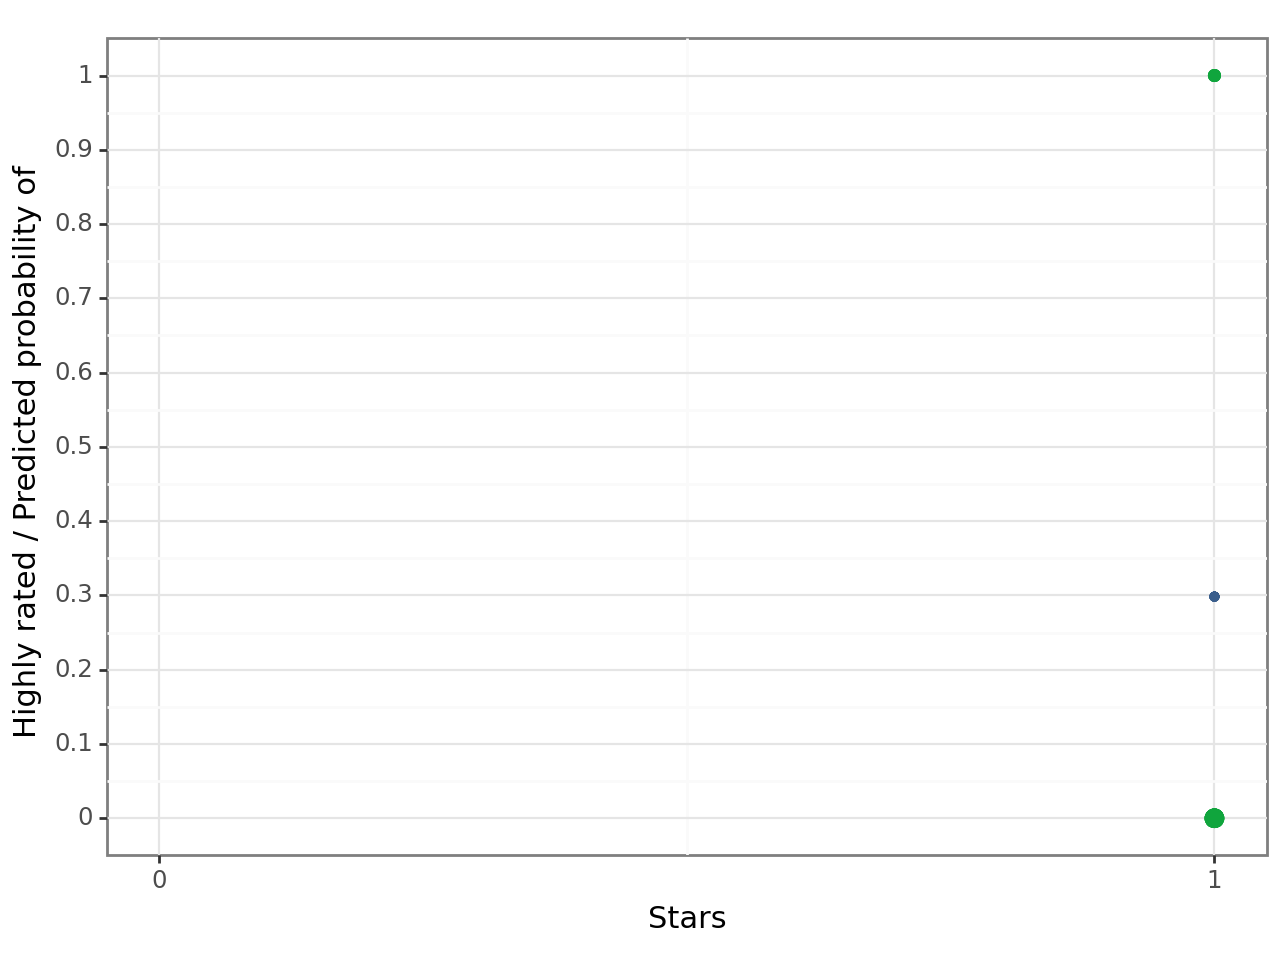

<Figure Size: (640 x 480)>

In [43]:
g1 = (
    ggplot(data=hotels)
    + geom_point(aes(x="stars", y="pred_2"), size=1, color=color[0])
    + geom_line(aes(x="stars", y="pred_2"), colour=color[0], size=0.7)
    + geom_point(
        aes(x="stars", y="highly_rated", size="weight_2"),
        fill=color[1],
        color=color[1],
        alpha=0.8,
        show_legend=False,
    )
    + labs(x="Stars", y="Highly rated / Predicted probability of ")
    + coord_cartesian(xlim=[0, 1], ylim=[0, 1])
    + scale_y_continuous(limits=[0, 1], breaks=seq(0, 1, 0.1))
    + scale_x_continuous(limits=[0, 1], breaks=seq(0, 1, 1))
    + theme_bw()
)
g1

## Histogram and Predicted probabilities

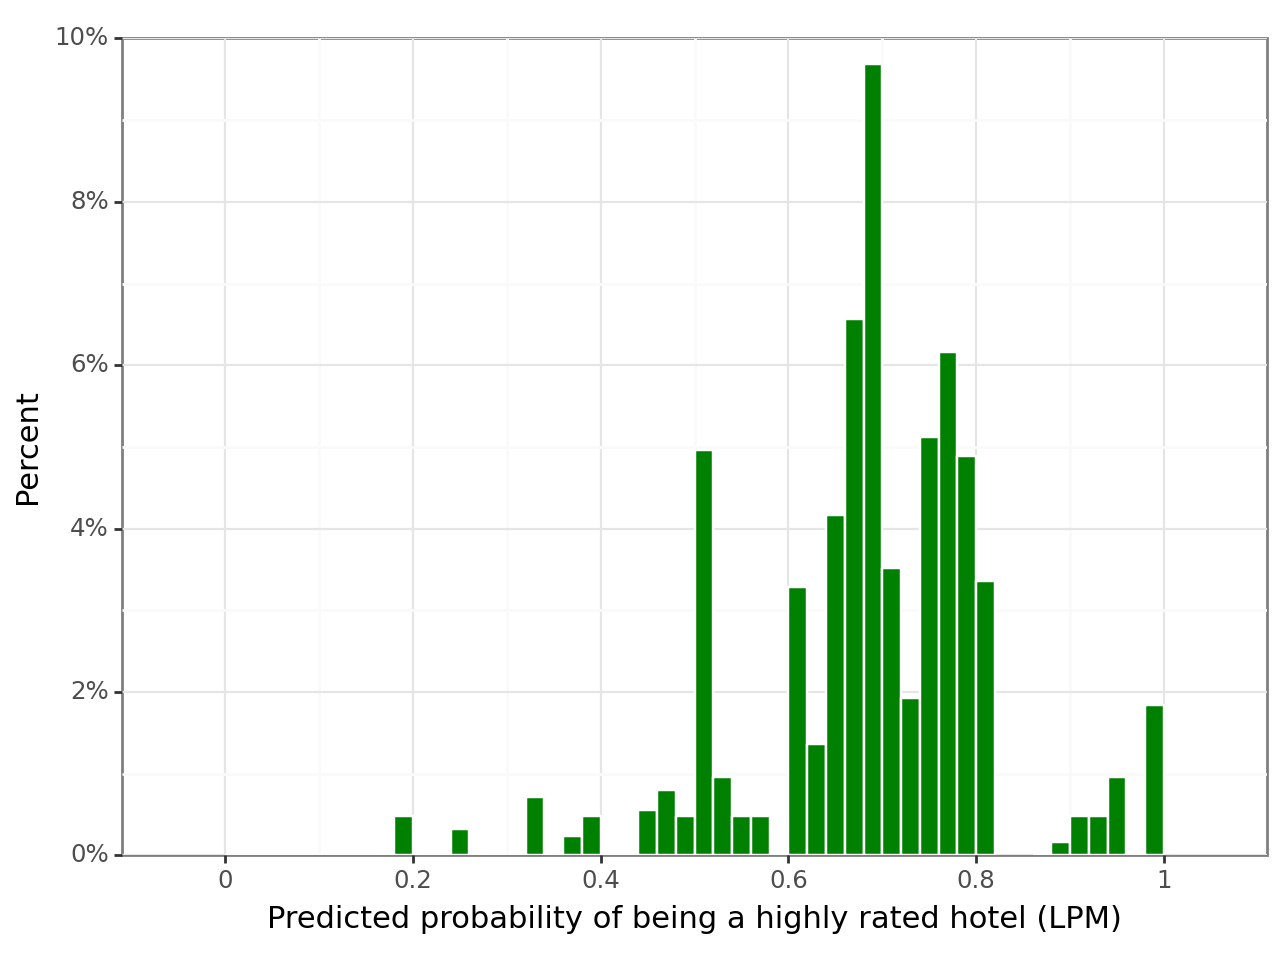

<Figure Size: (640 x 480)>

In [44]:
g3 = (
    ggplot(hotels, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill="green",  # Change the color to green
        closed="right",
    )
    + labs(x="Predicted probability of being a highly rated hotel (LPM)", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.1],  # Adjust the limits for the y-axis
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(),
    )
    + scale_x_continuous(expand=[0.1, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.2))
    + theme_bw()
)
g3

- The histogram shows that there is a wide range of predicted probabilities, from 0.18 to 1.03. This suggests that the model is able to distinguish between hotels that are very likely to be highly rated and those that are very unlikely to be highly rated.

- There is a relatively large number of hotels with predicted probabilities close to 0.5. This suggests that the model is not able to predict the probability of a hotel being highly rated with certainty for a significant number of hotels.

- The skewness of the histogram to the right suggests that there are more hotels that are likely to be highly rated than there are hotels that are unlikely to be highly rated. This is consistent with the fact that the mean predicted probability is 0.7659, which is greater than 0.5.

## LOGIT VS. PROBIT MODELS

In [45]:
y, X = dmatrices("highly_rated ~ stars+distance", data=hotels)

In [46]:
stargazer = Stargazer([lpm3])
stargazer.covariate_order(
    [
        "distance",
        "stars",
    ]
)
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer

In [47]:
logit = sm.Logit(y, X)

In [48]:
logit_result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.483951
         Iterations 6


In [49]:
logit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           highly_rated   No. Observations:                 1371
Model:                          Logit   Df Residuals:                     1368
Method:                           MLE   Df Model:                            2
Date:                Wed, 06 Dec 2023   Pseudo R-squ.:                  0.1108
Time:                        14:52:49   Log-Likelihood:                -663.50
converged:                       True   LL-Null:                       -746.13
Covariance Type:            nonrobust   LLR p-value:                 1.293e-36
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1043      0.311     -6.758      0.000      -2.715      -1.494
stars          1.0061      0.089     11.349      0.000       0.832       1.180
distance      -0.1333      0.030     -4.465      0.000      -0.192      -0.075
==============================================================================
"""

- Distance: The coefficient for distance is -0.1333, indicating a negative and statistically significant relationship (p < 0.01). This implies that as the distance of a hotel from the city center increases, the odds of it being highly rated decrease.


- Stars: The coefficient for stars is 1.0061, suggesting a positive and statistically significant relationship (p < 0.01). This indicates that as the number of stars a hotel possesses increases, the odds of it being highly rated also rise.


- For each **additional kilometer that a hotel is located from the city center**, the odds of it being highly rated decrease by **13.33%.**


- For each **additional star** that a hotel has, the odds of it being highly rated increase by **171.7%.**

### LOGIT Marginal effects

In [51]:
logit_margef_results = logit_result.get_margeff()
#Get marginal differences of the fitted model

In [52]:
logit_margef_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           highly_rated
Method:                          dydx
At:                           overall
==============================================================================
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
stars          0.1575      0.012     13.372      0.000       0.134       0.181
distance      -0.0209      0.005     -4.552      0.000      -0.030      -0.012
==============================================================================
"""

- The marginal effect for **stars** is **0.1575**, indicating that for each additional star a hotel possesses, the probability of it being highly rated __increases by 15.75%__. This is statistically significant (p < 0.01).

- The marginal effect for **distance** is **-0.0209**, indicating that for each additional kilometer a hotel is located from the city center, the probability of it being highly rated __decreases by 2.09%__. This is also statistically significant (p < 0.01).

The marginal effect for stars suggests that increasing the number of stars a hotel has has a substantial positive impact on the probability of it being highly rated. For example, a hotel with 4 stars has a 15.75% higher probability of being highly rated than a hotel with 3 stars.

The marginal effect for distance suggests that increasing the distance a hotel is located from the city center has a small but statistically significant negative impact on the probability of it being highly rated. For example, a hotel located 1 kilometer from the city center has a 2.09% higher probability of being highly rated than a hotel located 2 kilometers from the city center.

In [53]:
hotels["pred_logit"] = logit_result.predict()

In [54]:
hotels["pred_logit"].describe()

count    1371.000000
mean        0.765864
std         0.151046
min         0.106708
25%         0.705605
50%         0.814611
75%         0.864549
max         0.947833
Name: pred_logit, dtype: float64